In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.environ['PYTHONPATH'] += ":/content/drive/My Drive/Colab Notebooks/time-serie forecasting/"

**Import Libraries**

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error


import datetime
from datetime import date
import random


import warnings
warnings.filterwarnings('ignore')

**Import Data**

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/time-serie forecasting/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [5]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [0]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H')

In [0]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))

In [8]:
ts = data['2017-09-29':'2018-09-29']
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
date_time,,,,,,,,,
2017-09-29 00:00:00,None,286.22,0.0,0.0,1,Clear,sky is clear,2017-09-29 00:00:00,751
2017-09-29 01:00:00,None,284.75,0.0,0.0,1,Clear,sky is clear,2017-09-29 01:00:00,432
2017-09-29 02:00:00,None,284.42,0.0,0.0,1,Clear,sky is clear,2017-09-29 02:00:00,310
2017-09-29 03:00:00,None,284.15,0.0,0.0,1,Clear,sky is clear,2017-09-29 03:00:00,348
2017-09-29 04:00:00,None,283.62,0.0,0.0,1,Clear,sky is clear,2017-09-29 04:00:00,860


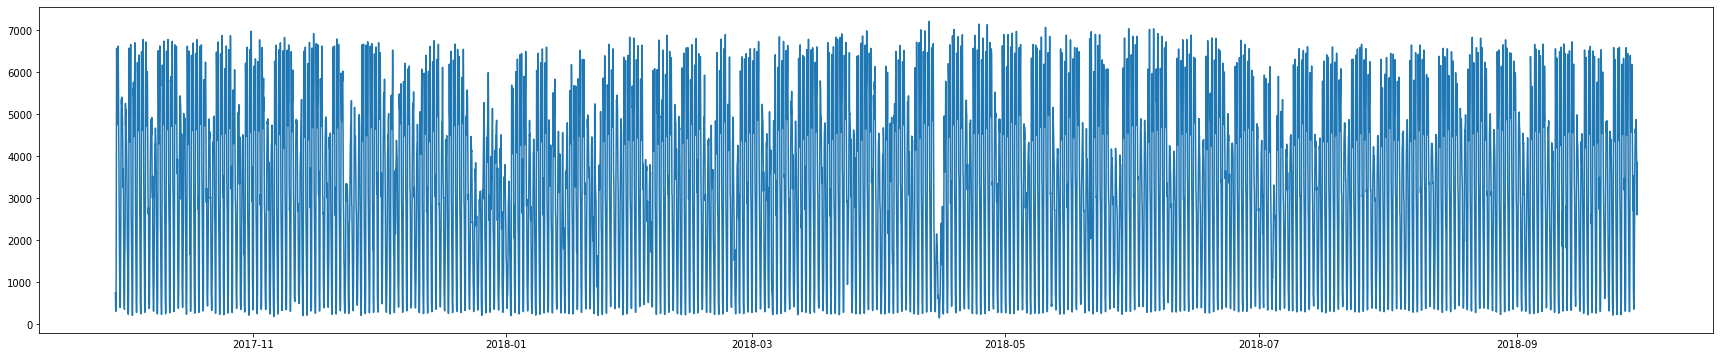

In [9]:
plt.figure(figsize=(30,6))
plt.plot(ts.traffic_volume)
plt.show()

Train/Test Split

In [0]:
split_date = '2018-08-30'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

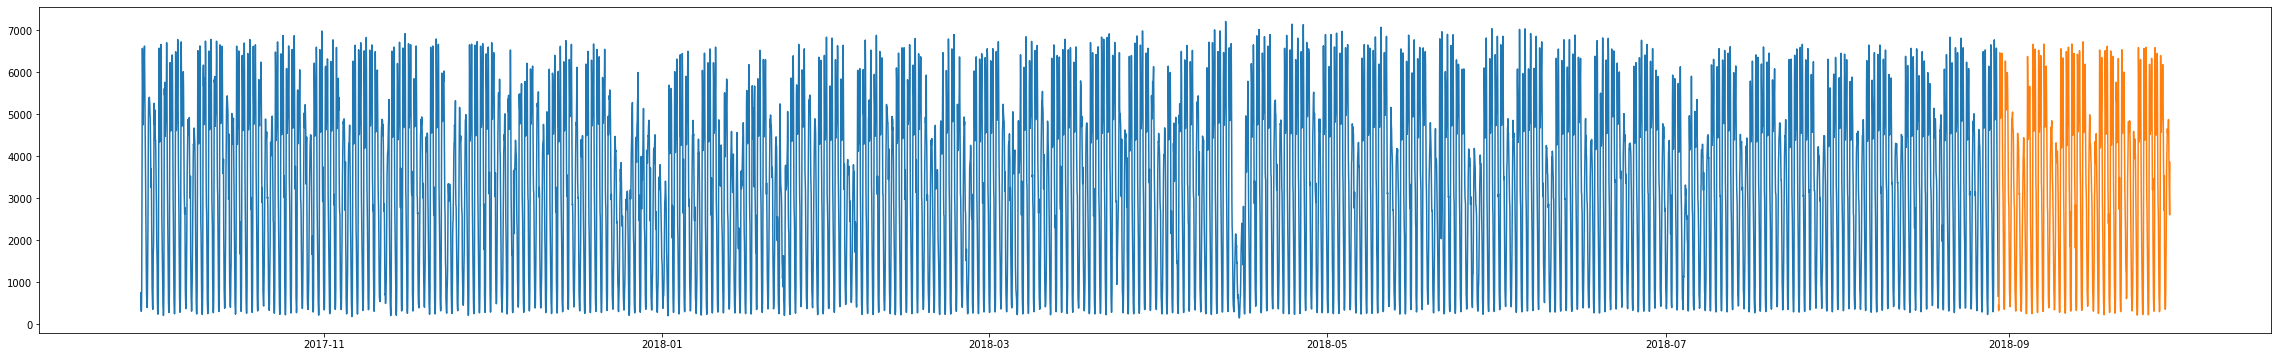

In [11]:
plt.figure(figsize=(40,6))
plt.plot(ts_train.traffic_volume)
plt.plot(ts_test.traffic_volume)
plt.show()

Simple Prophet Model

In [12]:
ts_train.reset_index(drop=True).rename(columns={'date_time':'ds', 'traffic_volume':'y'}).head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,y
0,None,286.22,0.0,0.0,1,Clear,sky is clear,2017-09-29 00:00:00,751
1,None,284.75,0.0,0.0,1,Clear,sky is clear,2017-09-29 01:00:00,432
2,None,284.42,0.0,0.0,1,Clear,sky is clear,2017-09-29 02:00:00,310
3,None,284.15,0.0,0.0,1,Clear,sky is clear,2017-09-29 03:00:00,348
4,None,283.62,0.0,0.0,1,Clear,sky is clear,2017-09-29 04:00:00,860


In [0]:
ts_train = ts_train.rename(columns={'date_time':'ds', 'traffic_volume':'y'})

In [14]:
# Setup and train model
model = Prophet()
model.fit(ts_train)
#model.fit(ts_train.reset_index().rename(columns={'date_time':'ds', 'traffic_volume':'y'}))

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [0]:
# Predict on training set with model
ts_test_fcst = model.predict(df=ts_test.reset_index(drop=True).rename(columns={'date_time':'ds'}))

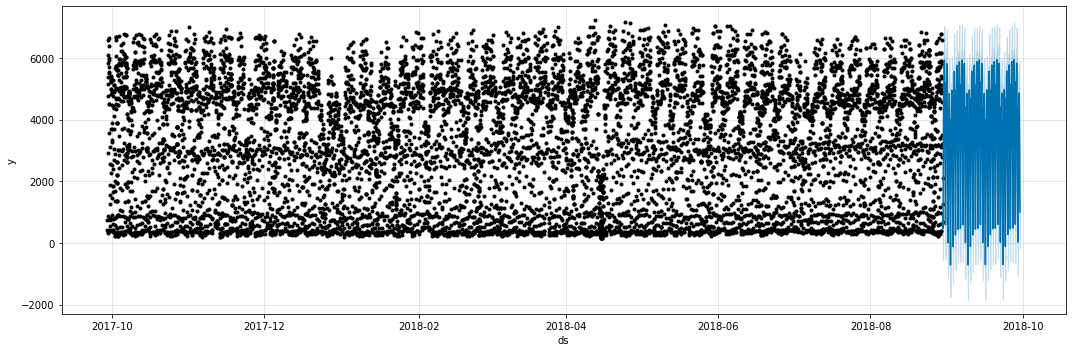

In [16]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(ts_test_fcst, ax=ax)

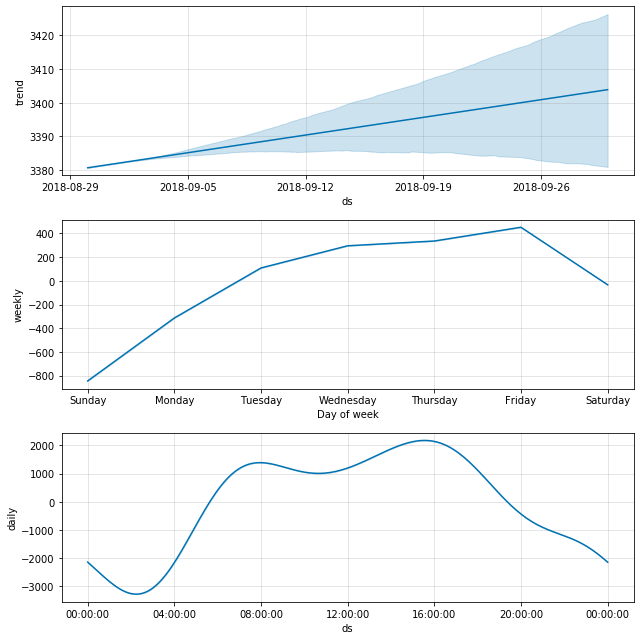

In [17]:
# Plot the components
fig = model.plot_components(ts_test_fcst)

**Compare Forecast to Actuals**

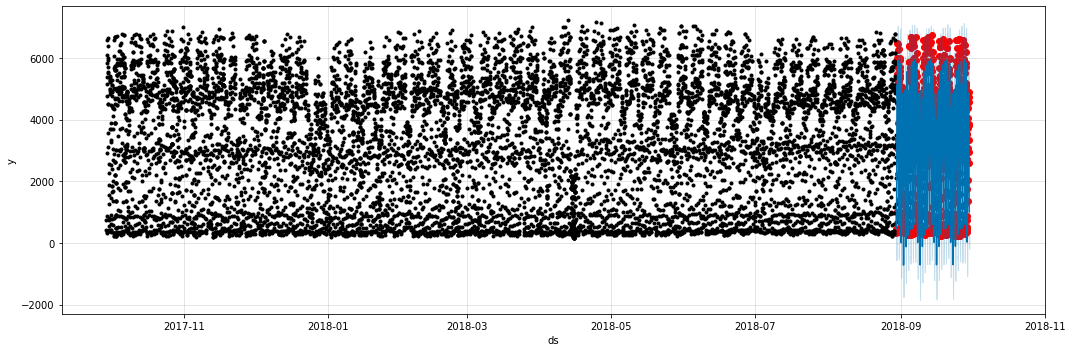

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.traffic_volume, color='r')
fig = model.plot(ts_test_fcst, ax=ax)

Lastest week predictions

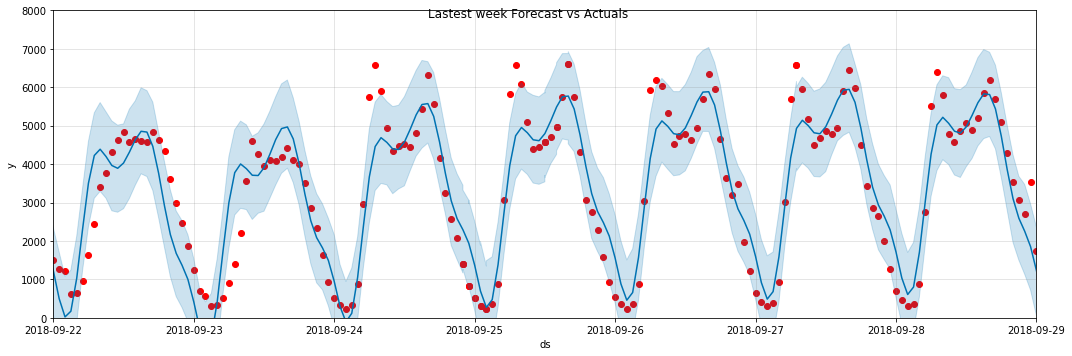

In [19]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.traffic_volume, color='r')
fig = model.plot(ts_test_fcst, ax=ax)
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))

ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

**Error Metrics**

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
'''
print('Train Mean Absolute Error:', mean_absolute_error(train_y_i[0], ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y_i[0], ts_train_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(train_y_i[0], ts_train_fcst[:,0]))
'''
print('Test Mean Absolute Error:', mean_absolute_error(ts_test['traffic_volume'], ts_test_fcst['yhat']))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_test['traffic_volume'],ts_test_fcst['yhat'])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_test['traffic_volume'],ts_test_fcst['yhat']))

Test Mean Absolute Error: 624.7620727542363
Test Root Mean Squared Error: 817.7455991620773
Test Mean Absolute percentage Error: 40.585824073313645


**Adding Regressor**

In [22]:
# Setup and train model with holidays
model_with_temp = Prophet()
model_with_temp.add_regressor('temp')
model_with_temp.fit(df=ts_train.reset_index(drop=True).rename(columns={'date_time':'ds', 'traffic_volume':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [0]:
ts_test_fcst_tem = model_with_temp.predict(df=ts_test.reset_index(drop=True).rename(columns={'date_time':'ds'}))

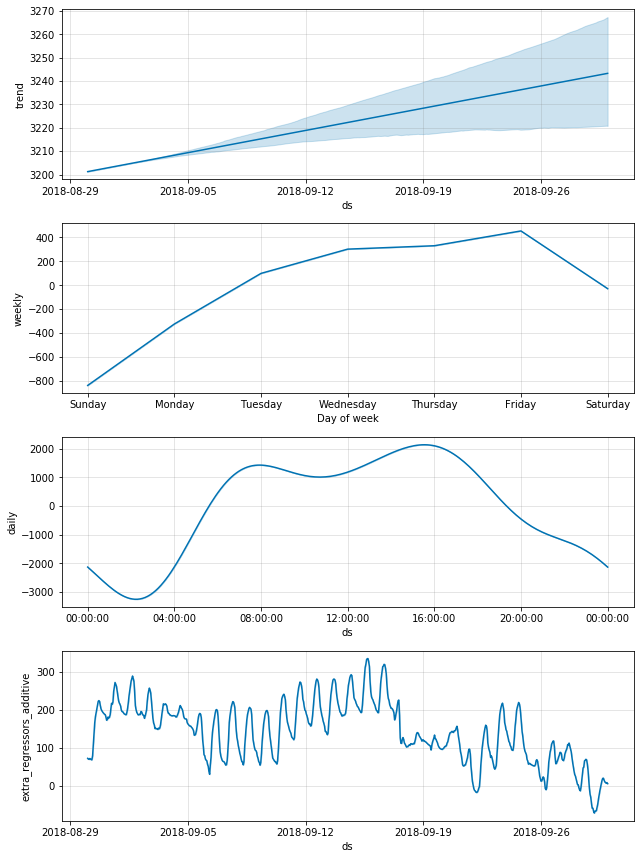

In [24]:
fig2 = model_with_temp.plot_components(ts_test_fcst_tem)

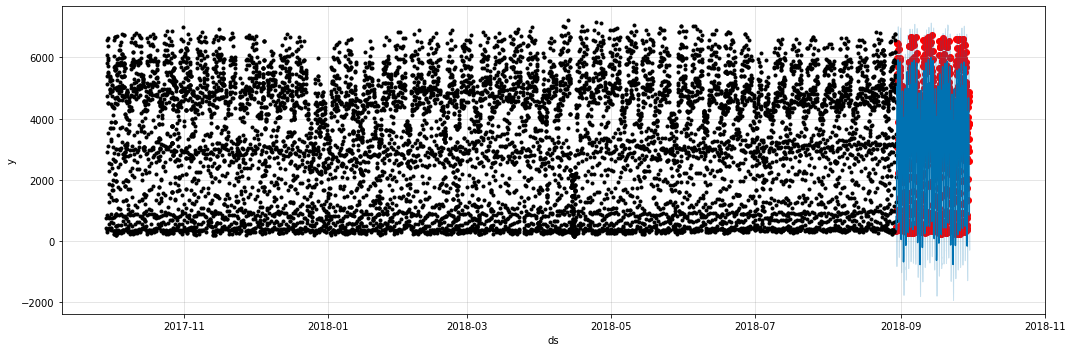

In [25]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.traffic_volume, color='r')
fig2 = model_with_temp.plot(ts_test_fcst_tem, ax=ax)

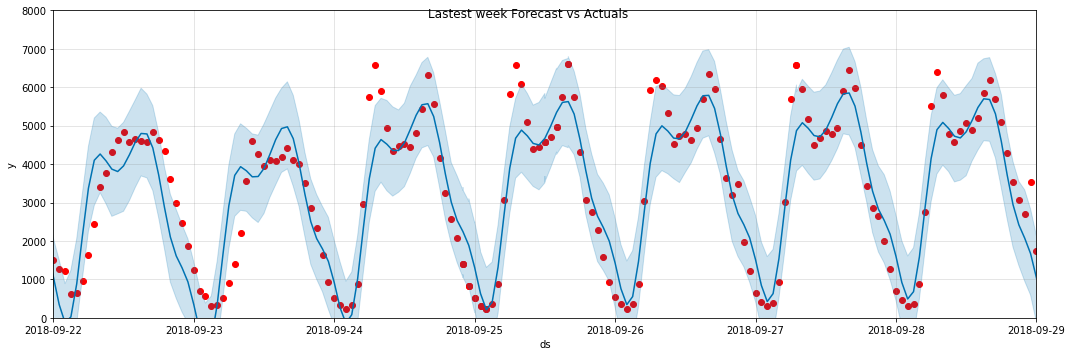

In [26]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.traffic_volume, color='r')
fig = model.plot(ts_test_fcst_tem, ax=ax)
#ax.set_xbound(lower='2018-09-22', upper='2018-09-29')
#ax.set_xbound(lower='2012-10-02 09:00:00', upper='2018-30-29 09:00:00')
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))

ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

**Error Metrics**

In [27]:
'''
print('Train Mean Absolute Error:', mean_absolute_error(train_y_i[0], ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y_i[0], ts_train_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(train_y_i[0], ts_train_fcst[:,0]))
'''
print('Test Mean Absolute Error:', mean_absolute_error(ts_test['traffic_volume'], ts_test_fcst_tem['yhat']))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_test['traffic_volume'],ts_test_fcst_tem['yhat'])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_test['traffic_volume'],ts_test_fcst_tem['yhat']))

Test Mean Absolute Error: 620.48326744171
Test Root Mean Squared Error: 817.6379467707934
Test Mean Absolute percentage Error: 39.614324725572146


**Adding more regressors**

In [28]:
# Setup and train model with many regressors
model_reg = Prophet()
model_reg.add_regressor('temp')
model_reg.add_regressor('rain_1h')
model_reg.add_regressor('snow_1h')
model_reg.add_regressor('clouds_all')
#model_reg.add_regressor('weather_main')
#model_reg.add_regressor('weather_description')

In [29]:
model_reg.fit(df=ts_train.reset_index(drop=True).rename(columns={'date_time':'ds', 'traffic_volume':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [0]:
ts_test_fcst_reg = model_reg.predict(df=ts_test.reset_index(drop=True).rename(columns={'date_time':'ds'}))

In [0]:
ts_test_fcst_reg.yhat[ts_test_fcst_reg.yhat < 0] = 0

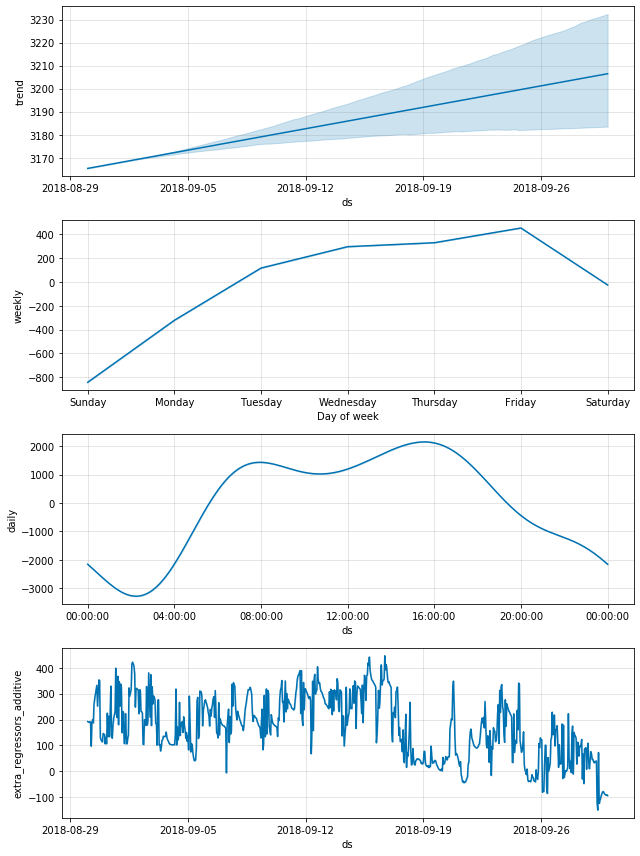

In [32]:
fig2 = model_reg.plot_components(ts_test_fcst_reg)

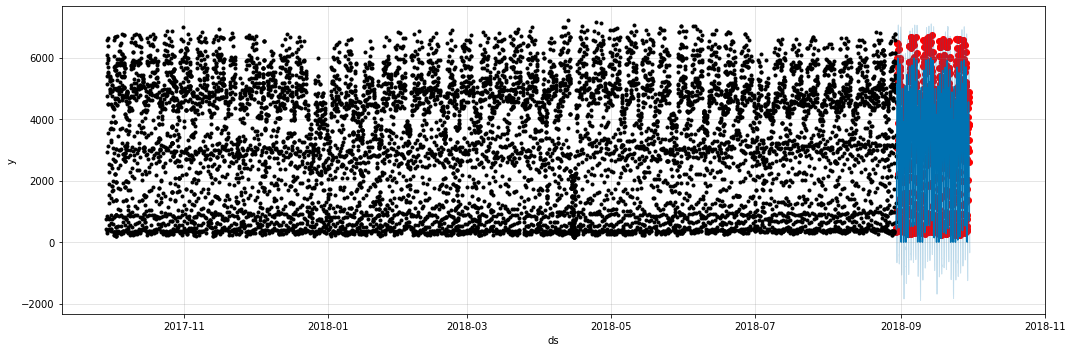

In [33]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.traffic_volume, color='r')
fig2 = model_with_temp.plot(ts_test_fcst_reg, ax=ax)

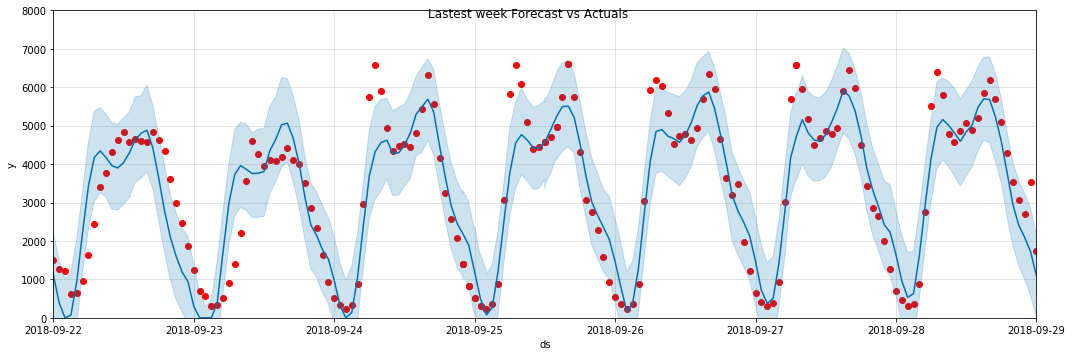

In [34]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.traffic_volume, color='r')
fig = model.plot(ts_test_fcst_reg, ax=ax)
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))

ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

**Error Metrics**

In [35]:
'''
print('Train Mean Absolute Error:', mean_absolute_error(train_y_i[0], ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y_i[0], ts_train_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(train_y_i[0], ts_train_fcst[:,0]))
'''
print('Test Mean Absolute Error:', mean_absolute_error(ts_test['traffic_volume'], ts_test_fcst_reg['yhat']))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_test['traffic_volume'],ts_test_fcst_reg['yhat'])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_test['traffic_volume'],ts_test_fcst_reg['yhat']))

Test Mean Absolute Error: 609.7861799809166
Test Root Mean Squared Error: 814.0950075671922
Test Mean Absolute percentage Error: 36.77654268463877


**Adding categorical features**

In [0]:
ts_train_dm = pd.get_dummies(ts_train, prefix_sep="__",columns=['weather_main','weather_description'])
ts_test_dm = pd.get_dummies(ts_test, prefix_sep="__",columns=['weather_main','weather_description'])

In [37]:
ts_train_dm.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'ds', 'y',
       'weather_main__Clear', 'weather_main__Clouds', 'weather_main__Drizzle',
       'weather_main__Fog', 'weather_main__Haze', 'weather_main__Mist',
       'weather_main__Rain', 'weather_main__Smoke', 'weather_main__Snow',
       'weather_main__Thunderstorm', 'weather_description__Sky is Clear',
       'weather_description__broken clouds', 'weather_description__drizzle',
       'weather_description__few clouds', 'weather_description__fog',
       'weather_description__haze',
       'weather_description__heavy intensity drizzle',
       'weather_description__heavy intensity rain',
       'weather_description__heavy snow',
       'weather_description__light intensity drizzle',
       'weather_description__light intensity shower rain',
       'weather_description__light rain',
       'weather_description__light shower snow',
       'weather_description__light snow', 'weather_description__mist',
       'weather_desc

**Create model with all the feature**

In [39]:
# Setup and train model with many regressors
model_all_reg = Prophet()
model_all_reg.add_regressor('temp')
model_all_reg.add_regressor('rain_1h')
model_all_reg.add_regressor('snow_1h')
model_all_reg.add_regressor('clouds_all')
model_all_reg.add_regressor('weather_main__Clear')
model_all_reg.add_regressor('weather_main__Clouds')
model_all_reg.add_regressor('weather_main__Drizzle')
model_all_reg.add_regressor('weather_main__Fog')
model_all_reg.add_regressor('weather_main__Haze')
model_all_reg.add_regressor('weather_main__Mist')
model_all_reg.add_regressor('weather_main__Rain')
model_all_reg.add_regressor('weather_main__Thunderstorm')
model_all_reg.add_regressor('weather_description__Sky is Clear')
model_all_reg.add_regressor('clouds_all')
model_all_reg.add_regressor('clouds_all')
model_all_reg.add_regressor('clouds_all')
model_all_reg.add_regressor('clouds_all')
model_all_reg.add_regressor('clouds_all')
model_all_reg.add_regressor('clouds_all')
model_all_reg.add_regressor('clouds_all')
model_all_reg.add_regressor('clouds_all')
model_all_reg.add_regressor('weather_description__Sky is Clear')
model_all_reg.add_regressor('weather_description__broken clouds') 
model_all_reg.add_regressor('weather_description__drizzle')
model_all_reg.add_regressor('weather_description__few clouds') 
model_all_reg.add_regressor('weather_description__fog')
model_all_reg.add_regressor('weather_description__haze')
model_all_reg.add_regressor('weather_description__heavy intensity drizzle')
model_all_reg.add_regressor('weather_description__heavy intensity rain')
model_all_reg.add_regressor('weather_description__light intensity drizzle')
model_all_reg.add_regressor('weather_description__light rain') 
model_all_reg.add_regressor('weather_description__mist')
model_all_reg.add_regressor('weather_description__moderate rain')
model_all_reg.add_regressor('weather_description__overcast clouds')
model_all_reg.add_regressor('weather_description__proximity shower rain')
model_all_reg.add_regressor('weather_description__proximity thunderstorm')
model_all_reg.add_regressor('weather_description__proximity thunderstorm with rain')
model_all_reg.add_regressor('weather_description__scattered clouds')
model_all_reg.add_regressor('weather_description__sky is clear')
model_all_reg.add_regressor('weather_description__thunderstorm')
model_all_reg.add_regressor('weather_description__thunderstorm with heavy rain')
model_all_reg.add_regressor('weather_description__thunderstorm with light drizzle')
model_all_reg.add_regressor('weather_description__thunderstorm with light rain')

In [40]:
model_all_reg.fit(df=ts_train_dm.reset_index(drop=True).rename(columns={'date_time':'ds', 'traffic_volume':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [0]:
ts_test_fcst_all = model_reg.predict(df=ts_test_dm.reset_index(drop=True).rename(columns={'date_time':'ds'}))
ts_test_fcst_all.yhat[ts_test_fcst_all.yhat < 0] = 0

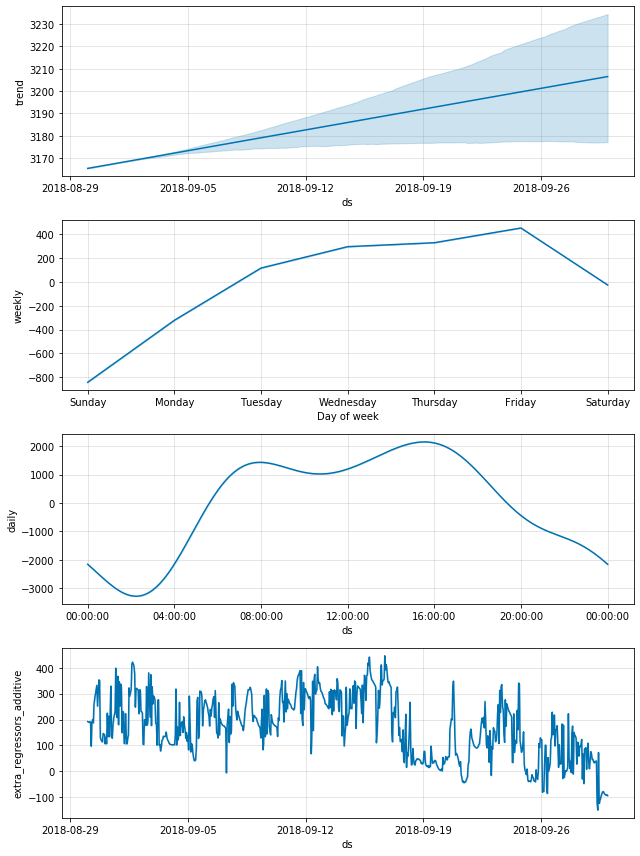

In [42]:
fig2 = model_reg.plot_components(ts_test_fcst_all)

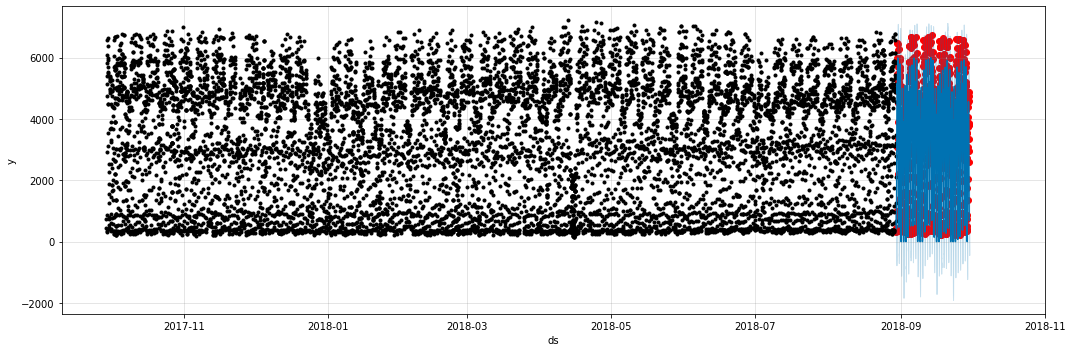

In [43]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.traffic_volume, color='r')
fig2 = model_with_temp.plot(ts_test_fcst_all, ax=ax)

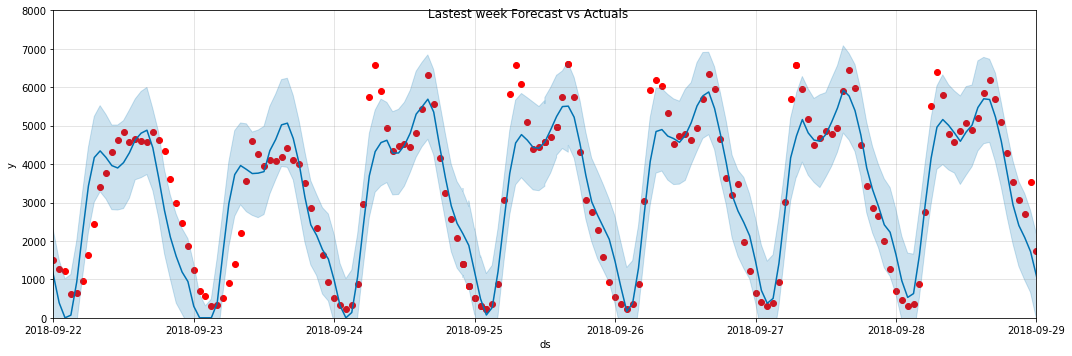

In [44]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.traffic_volume, color='r')
fig = model.plot(ts_test_fcst_all, ax=ax)
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))

ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

Error Metrics

In [45]:
'''
print('Train Mean Absolute Error:', mean_absolute_error(train_y_i[0], ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y_i[0], ts_train_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(train_y_i[0], ts_train_fcst[:,0]))
'''
print('Test Mean Absolute Error:', mean_absolute_error(ts_test['traffic_volume'], ts_test_fcst_all['yhat']))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_test['traffic_volume'],ts_test_fcst_all['yhat'])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_test['traffic_volume'],ts_test_fcst_all['yhat']))

Test Mean Absolute Error: 609.7861799809166
Test Root Mean Squared Error: 814.0950075671922
Test Mean Absolute percentage Error: 36.77654268463877
